In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
import tensorflow as tf

### Preprocessing the image data

In [85]:
train_direc='train1'
train_mask_direc='train_mask1'
test_direc='test1'
test_mask_direc='test_mask1'
### make several directories to store corresponding data
direcs=[train_direc,train_mask_direc,test_direc,test_mask_direc]
for i in direcs:
    os.mkdir(i)

In [86]:
file_names=glob.glob('train/*.tif')### get image and mask data

In [87]:
mask=[x for x in file_names if 'mask.tif' in x.split('_')]
train=[x for x in file_names if 'mask.tif' not in x.split('_')]

In [2]:
def sort_train_files(s):
    base=os.path.basename(s)
    num=int(base[:-5].replace('_',''))
    return num

def sort_mask_files(s):
    base=os.path.basename(s)
    num=int(base[:-9].replace('_',''))
    return num

In [89]:
mask.sort(key=sort_mask_files)
train.sort(key=sort_train_files)

In [90]:
test=train[-500:]
test_mask=mask[-500:]### Create a test set

In [91]:
### Redistribute the training images and masks to seperate files

for i,j in zip(train[:-500],mask[:-500]):
    os.rename(i,train_direc+'/'+os.path.basename(i))
    os.rename(j,train_mask_direc+'/'+os.path.basename(j))
for i,j in zip(test,test_mask):
    os.rename(i,test_direc+'/'+os.path.basename(i))
    os.rename(j,test_mask_direc+'/'+os.path.basename(j))   

In [6]:
TFRecords_filename='Train.tfrecords'### File name for the future tfrecord file
TFRecords_filename2='Train.tfrecords2'

In [3]:
train_images=glob.glob('train1/*.tif')
train_images.sort(key=sort_train_files)
train_mask=glob.glob('train_mask1/*.tif')
train_mask.sort(key=sort_mask_files)

In [4]:
test_images=glob.glob('test1/*.tif')
test_mask=glob.glob('test_mask1/*.tif')

In [60]:
def load_image(addr):
    '''
    Load and resize the images
    '''
    img=Image.open(addr)
    img=img.resize((128,128),resample=Image.BICUBIC)
    img=np.asarray(img)
    return img

def _bytes_feature(Input):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[Input]))


####################### Write resized data into a TFRecord file
writer=tf.python_io.TFRecordWriter(TFRecords_filename2)
num_records=len(train_images)
for i in range(num_records):

    if not i%500:
        print('Train data: {}/{}'.format(i,num_records))
    img=load_image(train_images[i])
    label=load_image(train_mask[i])

    feature={'images': _bytes_feature(img.tostring()),
    'masks':_bytes_feature(label.tostring())}

    example=tf.train.Example(features=tf.train.Features(feature=feature))

    writer.write(example.SerializeToString())
writer.close()

Train data: 0/5135
Train data: 500/5135
Train data: 1000/5135
Train data: 1500/5135
Train data: 2000/5135
Train data: 2500/5135
Train data: 3000/5135
Train data: 3500/5135
Train data: 4000/5135
Train data: 4500/5135
Train data: 5000/5135


In [44]:
def read_and_decode(filename_queue):
    '''
    Function to read and decode images from a tfrecord file
    '''

    reader=tf.TFRecordReader()

    _,serialized_example=reader.read(filename_queue)


    features=tf.parse_single_example(serialized_example,
                                    features={'images':tf.FixedLenFeature([],tf.string),'masks':tf.FixedLenFeature([],tf.string)})
    image=tf.decode_raw(features['images'],tf.uint8)
    mask=tf.decode_raw(features['masks'],tf.uint8)

#     image=tf.reshape(image,[420,580])
#     mask=tf.reshape(mask,[420,580])
    
    image=tf.reshape(image,[128,128])
    mask=tf.reshape(mask,[128,128])

    images,masks=tf.train.shuffle_batch([image,mask],batch_size=64,capacity=128,num_threads=2,min_after_dequeue=10)

    return images,masks

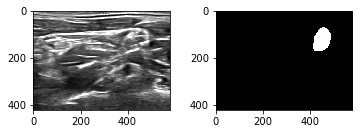

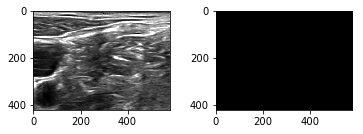

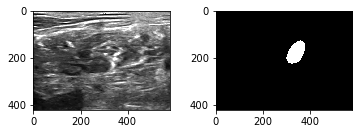

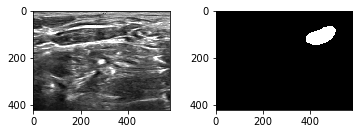

In [9]:
##### Check the integrity of images within TFrecrod file
filename_queue=tf.train.string_input_producer([TFRecords_filename],num_epochs=1)

image,mask=read_and_decode(filename_queue)
init_op=tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())

with tf.Session() as sess:
    sess.run(init_op)
    coord=tf.train.Coordinator()
    threads=tf.train.start_queue_runners(coord=coord)

    for i in range(2):
        img,label=sess.run([image,mask])
        for j in range(2):
            plt.subplot(2,2,j*2+1)
            plt.imshow(img[j,:,:],cmap='gray')
            plt.subplot(2,2,j*2+2)
            plt.imshow(label[j,:,:],cmap='gray')
            plt.show()
    coord.request_stop()
    coord.join(threads)

### Model Building

In [16]:
def input_scaler(x):
    '''
    Function to scale pixel value to between 0 to 1
    '''
    value=x/255.0

    return value.astype(np.int32)

In [11]:

### Functions to create various components of the network

initializer=tf.contrib.layers.variance_scaling_initializer()

def neural_net_input():
    x=tf.placeholder(tf.float32,[None,None,None])
    return x

def conv_2d(x,output_nums,conv_size,stride,activation='relu'):
    if activation=='relu':
        output=tf.layers.conv2d(x,output_nums,conv_size,strides=stride,padding='same',kernel_initializer=initializer)
        output=tf.nn.relu(output)
    elif activation=='sigmoid':
        output=tf.layers.conv2d(x,output_nums,conv_size,strides=stride,padding='same')
        output=tf.nn.sigmoid(output)
    else:
        output=tf.layers.conv2d(x,output_nums,conv_size,strides=stride,padding='same')
    return output


def max_pool2d(x,k_size,stride):
    output=tf.layers.max_pooling2d(x,k_size,strides=stride,padding='same')
    return output

def conv_trans(x,output_nums,conv_size,stride):
    output=tf.layers.conv2d_transpose(x,output_nums,conv_size,strides=stride,padding='same')
    
    return output


In [95]:

### Build the computational graph

tf.reset_default_graph()
import tensorlayer as tl
log_file='./logs/train3'
Graph=tf.Graph()

with Graph.as_default():
    
    Input=neural_net_input()
    x=tf.expand_dims(Input,3)
    mask=tf.placeholder(tf.int32,[None,None,None])
    with tf.name_scope('conv_3x3_0'):
        conv0=conv_2d(x,16,[3,3],1)
        conv0_1=conv_2d(conv0,16,[3,3],1)
    with tf.name_scope('maxpool_0'):
        pool0=max_pool2d(conv0_1,[2,2],2)
    with tf.name_scope('conv_3x3_1'):
        conv1=conv_2d(pool0,32,[3,3],1)
        conv2=conv_2d(conv1,32,[3,3],1)
    with tf.name_scope('maxpool_1'):
        pool1=max_pool2d(conv2,[2,2],2)
    with tf.name_scope('conv_3x3_2'):
        conv3=conv_2d(pool1,64,[3,3],1)
        conv4=conv_2d(conv3,64,[3,3],1)
    with tf.name_scope('maxpool_2'):
        pool2=max_pool2d(conv4,[2,2],2)
    with tf.name_scope('conv_3x3_3'):
        conv5=conv_2d(pool2,128,[3,3],1)
        conv6=conv_2d(conv5,128,[3,3],1)
    with tf.name_scope('upconv_1'):
        upconv1=conv_trans(conv6,64,[3,3],2)
    with tf.name_scope('concat_1'):
        concat_1=tf.concat([conv4,upconv1],3)
    with tf.name_scope('conv_3x3_4'):
        conv7=conv_2d(concat_1,64,[3,3],1)
        conv8=conv_2d(conv7,64,[3,3],1)
    with tf.name_scope('upconv_2'):
        upconv2=conv_trans(conv8,32,[3,3],2)
    with tf.name_scope('concat_2'):
        concat_2=tf.concat([conv2,upconv2],3)
    with tf.name_scope('conv_3x3_5'):
        conv9=conv_2d(concat_2,32,[3,3],1)
        conv10=conv_2d(conv9,32,[3,3],1)
    with tf.name_scope('upconv_3'):
        upconv3=conv_trans(conv10,16,[3,3],2)
    with tf.name_scope('concat_3'):
        concat_3=tf.concat([conv0_1,upconv3],3)
    with tf.name_scope('conv_3x3_6'):
        conv11=conv_2d(concat_3,16,[3,3],1)
        conv12=conv_2d(conv11,16,[3,3],1)
    with tf.name_scope('final_layer'):
        Final=conv_2d(conv12,1,[1,1],1,activation='sigmoid')
    
    
    
    with tf.name_scope('loss'):
        Mask=tf.expand_dims(mask,3)
        ### Compute 1-(Dice Coeficient) as network's loss function
        dice_loss=1-tl.cost.dice_coe(Final,tf.cast(Mask,tf.float32),axis=[0,1,2,3])
#         entropy=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=mask,logits=Final)
#         loss=tf.reduce_mean(entropy)
        loss_summ=tf.summary.scalar('cost',dice_loss)
        
    optimizer=tf.train.AdamOptimizer(learning_rate=0.0001,beta1=0.9)
    train_op=optimizer.minimize(dice_loss)
    
    filename_queue=tf.train.string_input_producer([TFRecords_filename2],num_epochs=500)
    images,masks=read_and_decode(filename_queue)
    file_writer=tf.summary.FileWriter(log_file,Graph)
    init_op=tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())

Entirety of the above computational graph can be seen below
<img src="graph-run=1.png">


The network has 15 3x3 convolutional layers, 3 Max-pooling layers, 3 transposed-convolution layers, and 3 tensor concatenation layers.

Trainable model parameters in this case come from convolution and deconvolution layers. Thus there are about 534816 trainable parameters in the model

In essence, the model structure is largely inspired by the U-net. However, there still exists some discrepancies between the above proposed model and U-net. Firstly, due to the constraint of computational power, above model is not as deep as U-net. Secondly, above model did use zero padding to maintain a consistent spatial shape for the feature maps during convolution operation. Thirdly, above model used only 3 concatenation layers to merge feature maps instead of 4 used in the U-net.

### Train and save the model

In [96]:
save_file='./image_segmentation3/seg'
num_epochs=200
batch_size=64
with tf.Session(graph=Graph) as sess:
    sess.run(init_op)
    n_batches=5135//batch_size
    iter=0
    coord=tf.train.Coordinator()
    threads=tf.train.start_queue_runners(coord=coord)
    for i in range(num_epochs):
        for _ in range(n_batches):
            iter+=1
            img,lab=sess.run([images,masks])
            lab=input_scaler(lab)
            img=input_scaler(img)
            img=img.astype(np.float32)
            sess.run(train_op,feed_dict={Input:img,mask:lab})
            if iter%10==0:
                summary_val=loss_summ.eval(feed_dict={Input:img,mask:lab})
                file_writer.add_summary(summary_val,iter)
        current_loss=sess.run(dice_loss,feed_dict={Input:img,mask:lab})
        print('Epoch:{}/{}...... Loss: {}'.format(i+1,num_epochs,current_loss))
    
    Saver=tf.train.Saver()
    Saver.save(sess,save_file)
    coord.request_stop()
    coord.join(threads)        

Epoch:1/200...... Loss: 0.9045027494430542
Epoch:2/200...... Loss: 0.829500138759613
Epoch:3/200...... Loss: 0.7454453706741333
Epoch:4/200...... Loss: 0.7394236326217651
Epoch:5/200...... Loss: 0.74959796667099
Epoch:6/200...... Loss: 0.7588839530944824
Epoch:7/200...... Loss: 0.7082983255386353
Epoch:8/200...... Loss: 0.6043993234634399
Epoch:9/200...... Loss: 0.5721170902252197
Epoch:10/200...... Loss: 0.5533362030982971
Epoch:11/200...... Loss: 0.622979998588562
Epoch:12/200...... Loss: 0.6647653579711914
Epoch:13/200...... Loss: 0.6957211494445801
Epoch:14/200...... Loss: 0.6243546009063721
Epoch:15/200...... Loss: 0.6170821785926819
Epoch:16/200...... Loss: 0.6274857521057129
Epoch:17/200...... Loss: 0.5656026005744934
Epoch:18/200...... Loss: 0.5971155166625977
Epoch:19/200...... Loss: 0.5033293962478638
Epoch:20/200...... Loss: 0.4257039427757263
Epoch:21/200...... Loss: 0.45144450664520264
Epoch:22/200...... Loss: 0.47214412689208984
Epoch:23/200...... Loss: 0.5052870512008667

Epoch:183/200...... Loss: 0.11216872930526733
Epoch:184/200...... Loss: 0.14773499965667725
Epoch:185/200...... Loss: 0.12258285284042358
Epoch:186/200...... Loss: 0.12968140840530396
Epoch:187/200...... Loss: 0.16975510120391846
Epoch:188/200...... Loss: 0.22018373012542725
Epoch:189/200...... Loss: 0.17626017332077026
Epoch:190/200...... Loss: 0.12877249717712402
Epoch:191/200...... Loss: 0.07437199354171753
Epoch:192/200...... Loss: 0.07588285207748413
Epoch:193/200...... Loss: 0.07712048292160034
Epoch:194/200...... Loss: 0.0738099217414856
Epoch:195/200...... Loss: 0.07907843589782715
Epoch:196/200...... Loss: 0.09100693464279175
Epoch:197/200...... Loss: 0.08248716592788696
Epoch:198/200...... Loss: 0.08509141206741333
Epoch:199/200...... Loss: 0.10899442434310913
Epoch:200/200...... Loss: 0.09417867660522461


<img src="Capture1.png">

Above picture shows the change of loss during training


The model performance is evaluated through Intersection over union score, which is defined Intersection of two sets divided by the union of two sets, in our case, the predicted mask and groud truth mask repsectively. 

### Examples of predicted mask

INFO:tensorflow:Restoring parameters from ./image_segmentation3/seg


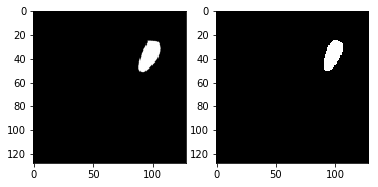

In [97]:
from PIL import Image
img=Image.open(train_images[0])
img=img.resize((128,128),resample=Image.BICUBIC)
img=np.asarray(img)
img=input_scaler(img)
img=np.expand_dims(img,axis=0)
loaded_graph=tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    loader=tf.train.import_meta_graph('./image_segmentation3/seg.meta')## Load the graph for the trained model
    loader.restore(sess,tf.train.latest_checkpoint('./image_segmentation3/'))## Restore the trained weights
    X=loaded_graph.get_tensor_by_name('Placeholder:0')
    logits=loaded_graph.get_tensor_by_name('final_layer/Sigmoid:0')
    result=sess.run(logits,feed_dict={X:img})
#Check the predicted mask for one training image
infered_mask=result[0,:,:,0]
mask_1=infered_mask
mask=Image.open(train_mask[0])
mask=mask.resize((128,128),resample=Image.BICUBIC)
plt.subplot(1,2,1)
plt.imshow(np.asarray(mask),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(mask_1>0.5,cmap='gray')  
plt.show()

INFO:tensorflow:Restoring parameters from ./image_segmentation3/seg


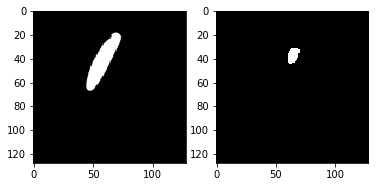

In [98]:
img=Image.open(test_images[0])
img=img.resize((128,128),resample=Image.BICUBIC)
img=np.asarray(img)
img=input_scaler(img)
img=np.expand_dims(img,axis=0)
loaded_graph=tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    loader=tf.train.import_meta_graph('./image_segmentation3/seg.meta')## Load the graph for the trained model
    loader.restore(sess,tf.train.latest_checkpoint('./image_segmentation3/'))## Restore the trained weights
    X=loaded_graph.get_tensor_by_name('Placeholder:0')
    logits=loaded_graph.get_tensor_by_name('final_layer/Sigmoid:0')
    result=sess.run(logits,feed_dict={X:img})
#Check the predicted mask for one test image
infered_mask=result[0,:,:,0]
mask_1=infered_mask
mask=Image.open(test_mask[0])
mask=mask.resize((128,128),resample=Image.BICUBIC)
plt.subplot(1,2,1)
plt.imshow(np.asarray(mask),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(mask_1>0.5,cmap='gray')  
plt.show()

According to above produced masks, it seems above model is capable of producing a coarse mask. 

### Mean IOU score on test and train images

In [73]:
def load_and_rescale(image,mask):
    img=Image.open(image)
    lab=Image.open(mask)
    img=img.resize((128,128),resample=Image.BICUBIC)
    lab=lab.resize((128,128),resample=Image.BICUBIC)
    img=np.asarray(img)
    lab=np.asarray(lab)
    img=input_scaler(img)
    lab=input_scaler(lab)
    img=np.expand_dims(img,axis=0)
    lab=np.expand_dims(lab,axis=0)
    lab=np.expand_dims(lab,axis=3)
    lab=lab.astype(np.float32)
    return img,lab

def IOU(y_pred, y_true):
    """
    Returns a IOU score
    """
    H, W, _ = y_pred.shape[1:]
    pred_flat = np.reshape(y_pred, [-1, H * W])
    true_flat = np.reshape(y_true, [-1, H * W])
    intersection = 2 * np.sum(pred_flat * true_flat, axis=1) + 1e-7
    denominator = np.sum(pred_flat, axis=1) + np.sum(true_flat, axis=1) + 1e-7
    return np.mean(intersection / denominator)


In [100]:
from PIL import Image
import tensorlayer as tl
tf.reset_default_graph()
loaded_graph=tf.Graph()
dice=[]
with tf.Session(graph=loaded_graph) as sess:
    loader=tf.train.import_meta_graph('./image_segmentation3/seg.meta')## Load the graph for the trained model
    loader.restore(sess,tf.train.latest_checkpoint('./image_segmentation3/'))## Restore the trained weights
    X=loaded_graph.get_tensor_by_name('Placeholder:0')
    logits=loaded_graph.get_tensor_by_name('final_layer/Sigmoid:0')
    for i,j in zip(train_images,train_mask):
        img,lab=load_and_rescale(i,j)
        result=sess.run(logits,feed_dict={X:img})
        dice_co=IOU(result>0.5, lab)
        dice.append(dice_co)
        
print("Mean IOU Score for train images: {}".format(np.mean(dice)))

INFO:tensorflow:Restoring parameters from ./image_segmentation3/seg
Mean IOU Score for train images: 0.9124739698177093


In [99]:
from PIL import Image
import tensorlayer as tl
tf.reset_default_graph()
loaded_graph=tf.Graph()
dice=[]
with tf.Session(graph=loaded_graph) as sess:
    loader=tf.train.import_meta_graph('./image_segmentation3/seg.meta')## Load the graph for the trained model
    loader.restore(sess,tf.train.latest_checkpoint('./image_segmentation3/'))## Restore the trained weights
    X=loaded_graph.get_tensor_by_name('Placeholder:0')
    logits=loaded_graph.get_tensor_by_name('final_layer/Sigmoid:0')
    for i,j in zip(test_images,test_mask):
        img,lab=load_and_rescale(i,j)
        result=sess.run(logits,feed_dict={X:img})
        dice_co=IOU(result>0.5, lab)
        dice.append(dice_co)
        
print("Mean IOU Score for test images: {}".format(np.mean(dice)))

INFO:tensorflow:Restoring parameters from ./image_segmentation3/seg
Mean IOU Score for test images: 0.600354976171646


From above mean scores, the model proposed seems to be overfitting the training dataset, and to further improve the performance we may need to generate some more training images with data augmentation or reduce model complexity a bit. Another unique aspect of this particular problem is lots of current training images correspond to a blank groud truth, which makes our data highly imbalanced. Thus a model with an additional classification head to detect whether a specific image should have a mask or not, might be worth of further experimentation.